In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import prune_and_initilize, get_prunned_model, initialize_sparse_model
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


In [3]:
my_dataset = fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 28, 28, 1)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 28, 28, 1)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  
reduce = 1

def get_model(compile_model_flag=True, lr=0.001, activation='relu', reduce = reduce):
    input_dim=784
    output_size = 10
#     initializer = initializers.RandomNormal(mean=0, stddev=0.1)
    initializer = initializers.glorot_normal()
#     initializer = initializers.VarianceScaling(4.0, mode='fan_avg')
    # Creo el modelo
    
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(28,28, 1), activation='relu'))
    # model.add(MaxPool2D(2))
    model.add(Conv2D(64, 3, activation=activation))
    model.add(MaxPool2D(2))
    model.add(Conv2D(128, 3, activation=activation))
    model.add(Conv2D(64, 3, activation=activation))
    #model.add(Conv2D(32, 3, activation=activation))
    model.add(Flatten())
    model.add(Dense(output_size, activation='softmax',
                    name='Salida', input_dim=input_dim,
                    kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
Salida (Dense)               (None, 10)                4

In [6]:
def get_callbacks(filename):
    return [
        ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=np.sqrt(0.1), patience=10, verbose=0, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
    ]

In [7]:
def train_model(activation='relu', epochs = 10, batch_size = 1024):
    model = get_model(activation=activation)
    # Save initial weights
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
    model.save_weights(initial_filename)
    history = model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
               validation_data = (X_val, y_val),
               verbose=2, 
               callbacks=get_callbacks(best_filename)
              )
    model.load_weights(best_filename)
    act = model.get_config()['layers'][0]['config']['activation']
    print(f'{act}: {model.evaluate(X_test, y_test, verbose=0)}')
    del model
    return history

Epoch 1/10
50/50 - 2s - loss: 0.9778 - accuracy: 0.6466 - val_loss: 0.5872 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 2/10
50/50 - 2s - loss: 0.5083 - accuracy: 0.8105 - val_loss: 0.4485 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 3/10
50/50 - 1s - loss: 0.4237 - accuracy: 0.8482 - val_loss: 0.4002 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 4/10
50/50 - 2s - loss: 0.3698 - accuracy: 0.8670 - val_loss: 0.3530 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 5/10
50/50 - 1s - loss: 0.3435 - accuracy: 0.8766 - val_loss: 0.3392 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 6/10
50/50 - 1s - loss: 0.3123 - accuracy: 0.8887 - val_loss: 0.3159 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 7/10
50/50 - 1s - loss: 0.2903 - accuracy: 0.8973 - val_loss: 0.3206 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 8/10
50/50 - 2s - loss: 0.2763 - accuracy: 0.9008 - val_loss: 0.2923 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 9/10
50/50 - 2s - loss: 0.2599 - accuracy: 0.9063 - val_loss: 0.2745 - val_accuracy: 0.9001 - lr: 0.0010
E

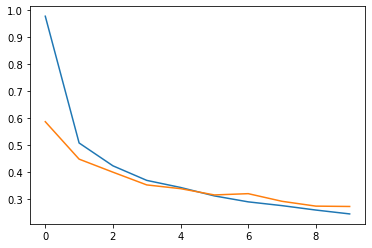

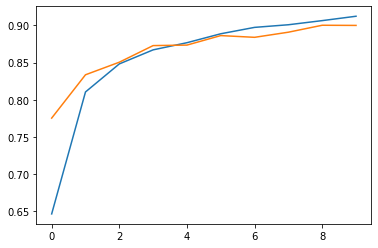

In [8]:
# activations = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu']
activations = ['relu']
for activation in activations:
    history = train_model(activation)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

In [9]:
def get_untrained_curve(activation):
    pms = np.linspace(0.001, 0.999, 50)
    accs_nt = []
    best_acc = 0
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
        
    best_model = get_model(activation=activation)    
    best_model.load_weights(best_filename)
    for pm in pms:
        # print(model_pruned_layers.get_config()['layers'][0]['config']['layer']['config']['activation'])
        model_pruned_layers_not_trained = prune_and_initilize(best_model, pm, initial_filename)
        # print(model_pruned_layers_not_trained.get_config()['layers'][0]['config']['layer']['config']['activation'])
        actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
        print(actual_acc, pm)
        if actual_acc>best_acc:
            best_acc = actual_acc
            best_pm = pm
            model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
        accs_nt.append(actual_acc)
    np.save(f'acc_not_train_prunned_{activation}_relu_20_epochs_reduce_{reduce}_normal_glorot_50.npy', [pms, accs_nt])
    model_pruned_layers_not_trained_best.save_weights(f'best_untrained_acc_{activation}_{int(best_pm*1000)/10}_{int(best_acc*1000)/10}.hdf5')
    return pms, accs_nt, best_pm, best_acc

Instructions for updating:
Please use `layer.add_weight` method instead.
0.07209999859333038 0.001
0.10000000149011612 0.02136734693877551
0.10000000149011612 0.04173469387755102
0.10050000250339508 0.06210204081632653
0.17270000278949738 0.08246938775510204
0.1071000024676323 0.10283673469387755
0.16689999401569366 0.12320408163265306
0.1242000013589859 0.14357142857142857
0.17509999871253967 0.16393877551020408
0.13500000536441803 0.1843061224489796
0.18129999935626984 0.2046734693877551
0.38960000872612 0.2250408163265306
0.49869999289512634 0.24540816326530612
0.5532000064849854 0.26577551020408163
0.5916000008583069 0.28614285714285714
0.5771999955177307 0.30651020408163265
0.5584999918937683 0.32687755102040816
0.602400004863739 0.3472448979591837
0.6509000062942505 0.3676122448979592
0.6315000057220459 0.3879795918367347
0.6611999869346619 0.4083469387755102
0.6664999723434448 0.4287142857142857
0.652999997138977 0.4490816326530612
0.5953999757766724 0.46944897959183673
0.564999

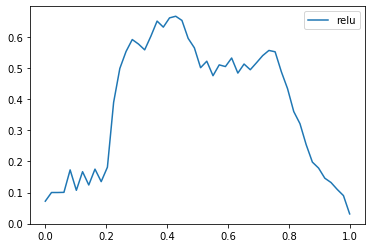

In [10]:
for activation in activations:
    pms, accs_nt, best_pm, best_acc = get_untrained_curve(activation)
    plt.plot(pms, accs_nt, label=f'{activation}')
    plt.legend()
    print(f'{activation}: {best_pm}, {best_acc}')